<class 'numpy.ndarray'>
X_train shape:  (125973, 41)
label 1
Prediction:  [[4.6629367e-15 1.0000000e+00]]
X_test shape: (41,)
Number of points in each region: 5000
Number of unique regions: 1
Region 0 score: 0.06094717959051155


c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


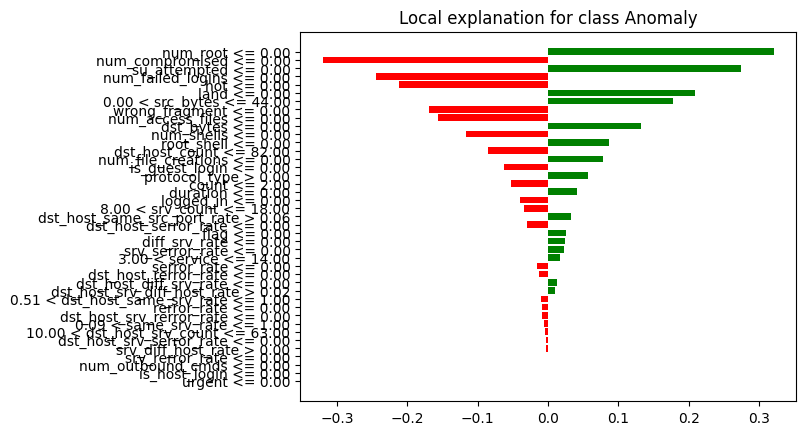

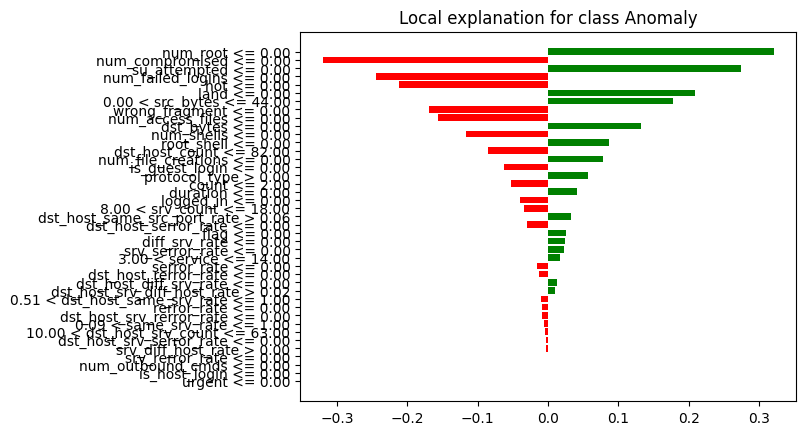

In [51]:
# import os
# # Ensure the directory exists before changing to it
# directory = 'Robust Network Intrusion Detection through Explainable Artificial Intelligence (XAI)'
# if not os.path.exists(directory):
#     os.makedirs(directory)  # Create the directory if it doesn't exist
# os.chdir(directory)  # Change to the directory where files are stored (main + utility)
save_loc = './results/'    			# location to save results
data_loc = 'dataset/'              # location of dataset

import numpy as np
import matplotlib.pyplot as plt
import pickle
import xgboost
import tensorflow as tf
import shap
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import utility_funcs as utf

np.random.seed(10)
# tf.random.set_seed(10)


data_kdd = utf.read_KDD(data_loc)

feature_names = data_kdd['feature_names']
X_train = data_kdd['X_train'].values
X_test = data_kdd['X_test'].values
with open(f"{save_loc}/model.pkl", "rb") as f:
    model = pickle.load(f)
# from sklearn.neural_network import MLPClassifier
print(type(data_kdd['X_train'].values))
# # instantiate an MLP with default settings (you can tweak hidden_layer_sizes, activation, solver, etc.)
# model = MLPClassifier(random_state=10, max_iter=200)

# fit on the KDD train set
model.fit(data_kdd['X_train'], data_kdd['Y_train_bin'])

# from pwla_lime.pwla_line_3d import MultiRegionLimeTabularExplainer3D, plot_decision_boundary_with_explanation3D
from lime.lime_tabular import LimeTabularExplainer
# from pwla_lime.pwla_cluster_3d import MultiRegionLimeTabularExplainer3D
from pwla_lime.pwla_line_3d import MultiRegionLimeTabularExplainer3D, plot_decision_boundary_with_explanation3D
from sklearn.neural_network import MLPClassifier

print("X_train shape: ", X_train.shape)

# Initialize multi-region LIME explainer
# pwla_explainer = MultiRegionLimeTabularExplainer3D(
#     X_train,
#     mode="classification",
#     feature_names=feature_names,
#     # class_names=[0, 1],
#     n_regions=41,
#     discretize_continuous=True,
#     verbose=True,
# )

# test_idx = 18
# test_instance =  X_test[test_idx]
# print(test_instance.shape)
# print(test_instance)
# print("Prediction: ",model.predict_proba(test_instance.reshape(1, -1)  ))

# predict_proba = model.predict_proba

# # Generate explanation
# pwla_explanation = pwla_explainer.explain_instance(
#     test_instance, predict_proba, num_features=3, num_samples=5000, labels=[1]
# )

# # Original lime

# lime_explainer = LimeTabularExplainer(
#     X_train,
#     mode="classification",
#     feature_names=feature_names,
#     class_names=["Class 0", "Class 1"],
#     discretize_continuous=True,
# )

# lime_explanation = lime_explainer.explain_instance(
#     test_instance, predict_proba, num_features=3, labels=[1]
# )


pwla_explainer = MultiRegionLimeTabularExplainer3D(
        X_train,
        mode="classification",
        feature_names=feature_names,
        class_names=["Normal", "Anomaly"],
        n_regions=1,
        discretize_continuous=True,
        verbose=True,
    )

test_idx = 18
# idx = data_kdd['Y_train'][data_kdd['Y_train']=='ipsweep'].index # get all locations where ipsweep attack occur (i.e., main attack class = Probe)
idx = data_kdd['Y_train'][data_kdd['Y_train']=='ipsweep'].index # get all locations where ipsweep attack occur (i.e., main attack class = Probe)


test_instance = data_kdd['X_train'].loc[idx[1]].values

print("label", data_kdd['Y_train_bin'].loc[idx[0]])
print("Prediction: ",model.predict_proba(test_instance.reshape(1, -1)  ))
print("X_test shape:", test_instance.shape)
predict_proba = model.predict_proba

# Generate explanation
pwla_explanation = pwla_explainer.explain_instance(
    test_instance, predict_proba, num_features=41, num_samples=5000,
)


pwla_explanation.as_pyplot_figure()
# pwla_explanation.show_in_notebook(show_table=True, show_all=False)


In [52]:
import numpy as np
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def global_rmse(explainer, X, predict_proba, predict, label=1,
                num_features=41, num_samples=5000):
    """
    Compute RMSE between true model probs and surrogate intercepts
    over all rows in X for a given label.
    """
    # 2.1 True model probabilities (P)
    P = predict_proba(X)[:, label]

    print("P shape: ", P)
    print("P true: ",  predict_proba(X))


    P_hat = []
    for xi in X:
        exp = explainer.explain_instance(
            xi, predict_proba,
            num_features=num_features,
            num_samples=num_samples,
        )
        P_hat.append(exp.local_pred)

    flat_arr = np.array(P_hat).flatten()
    print("P_hat shape: ", flat_arr)


    # P_hat = np.array(P_hat)
    #convert
    # 2.3 Compute RMSE
    return np.sqrt(mean_squared_error(P, flat_arr))


# — set up your explainers (reuse your existing ones) —
lime_explainer = LimeTabularExplainer(
    X_train,
    mode="classification",
    feature_names=feature_names,
    class_names=["Normal","Anomaly"],
    discretize_continuous=True,
    verbose=False,
)



import numpy as np
from sklearn.metrics import mean_squared_error



# with plt.style.context("ggplot"):
#     fig = plt.figure(figsize=(8, 6))
#     plt.barh(range(len(feature_names)), np.mean(np.abs(model.coefs_[0]), axis=1),
#              color=["red" if coef < 0 else "green" for coef in np.mean(model.coefs_[0], axis=1)])
#     plt.yticks(range(len(feature_names)), feature_names)
#     plt.title("Feature Importances (Approximated)")

# assume pwla_explainer already defined as MultiRegionLimeTabularExplainer3D

# # — pick a manageable subset of X_test if n is large (optional) —
X_eval = X_test  # e.g. first 100 samples
print("X_eval shape: ", X_eval.shape)
# need to provide X_eval as perterbed samples

Y_test = data_kdd['Y_test_bin'].values
print(Y_test[:1])


# 3. Compute and compare
rmse_lime = global_rmse(lime_explainer, X_eval, model.predict_proba, model.predict)
rmse_pwla = global_rmse(pwla_explainer, X_eval, model.predict_proba, model.predict)

print(f"Global RMSE (LIME) : {rmse_lime:.4f}")
print(f"Global RMSE (PWLA) : {rmse_pwla:.4f}")


X_eval shape:  (22544, 41)
[1]
P shape:  [1.00000000e+00 1.00000000e+00 0.00000000e+00 ... 0.00000000e+00
 4.01550807e-33 9.99990453e-01]
P true:  [[0.00000000e+00 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]
 [1.00000000e+00 0.00000000e+00]
 ...
 [1.00000000e+00 0.00000000e+00]
 [1.00000000e+00 4.01550807e-33]
 [9.54668250e-06 9.99990453e-01]]


c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted w

KeyboardInterrupt: 

In [ ]:
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import mean_squared_error
import numpy as np

# 1) Instantiate a “vanilla” LIME explainer with the same settings
lime_explainer = LimeTabularExplainer(
    X_train,
    mode="classification",
    feature_names=feature_names,
    class_names=["Class 0", "Class 1"],
    discretize_continuous=True,
    verbose=True,
)

# 2) Generate a LIME explanation for the very same test instance + label
lime_exp = lime_explainer.explain_instance(
    test_instance,
    model.predict_proba,
    num_features=41,
    num_samples=5000,
    labels=[1]
)

# 3) Extract the perturbed neighborhood and predictions
#    Explanation.raw_data is a tuple (neigh_data, neigh_scaled, distances)
neigh_data, _, _ = lime_exp.raw_data
orig_preds_lime = model.predict_proba(neigh_data)[:, 1]     # true model’s P(label=1)
surrogate_preds_lime = lime_exp.local_pred[1]               # LIME’s surrogate predictions

# 4) Compute RMSE for LIME
rmse_lime = np.sqrt(mean_squared_error(orig_preds_lime, surrogate_preds_lime))

# 5) Do the same for your PWLA explainer
pwla_neigh_data, _, _ = pwla_explanation.raw_data
orig_preds_pwla = model.predict_proba(pwla_neigh_data)[:, 1]
surrogate_preds_pwla = pwla_explanation.local_pred[1]

rmse_pwla = np.sqrt(mean_squared_error(orig_preds_pwla, surrogate_preds_pwla))

# 6) Compare
print(f"LIME   RMSE (label=1): {rmse_lime:.4f}")
print(f"PWLA   RMSE (label=1): {rmse_pwla:.4f}")

Intercept 0.815279907516562
Prediction_local [0.55120976]
Right: 0.9999999999999953


c:\Users\Acer\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


AttributeError: 'Explanation' object has no attribute 'raw_data'

In [ ]:
idx = data_kdd['Y_train'][data_kdd['Y_train']=='ipsweep'].index # get all locations where ipsweep attack occur (i.e., main attack class = Probe)
print(data_kdd['X_train'].loc[idx[0]].shape)


(41,)
